# Objectives
>The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:
>
> 1. Predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.
>
> 2. Identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.


>  _Import required libraries_

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


> Generic Function to identify and plot missing values


In [4]:
def plot_missing_values(df,fig_x,fig_y):
    # check null value
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_values_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
    missing_values_df.sort_values('percent_missing', inplace=True, ascending=False)
    missing_values_df = missing_values_df[missing_values_df.percent_missing > 0]
    if len(missing_values_df) > 0:
        plt.figure(figsize=(fig_x,fig_y))
        sns.barplot(x = 'percent_missing',y = 'column_name',data = missing_values_df)
        plt.show()
    else:
        print("No data available")    

> #### Load the CSV file

In [5]:
df_sample = pd.read_csv("sample.csv")
df_sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


> #### Load the training set


In [6]:
pd.set_option('display.max_columns',230)
pd.options.mode.chained_assignment = None  # default='warn'
df_train = pd.read_csv("train.csv")
df_train.head(5)



,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [7]:

df_test = pd.read_csv("test.csv")
df_test.head()


,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,NaN,NaN,Na

> Check whether churn probability col exists in test data     

In [8]:
for col in df_train.columns:
    if col not in df_test.columns:
        print(col)
 

churn_probability


## _Data Cleaning_

> check null values

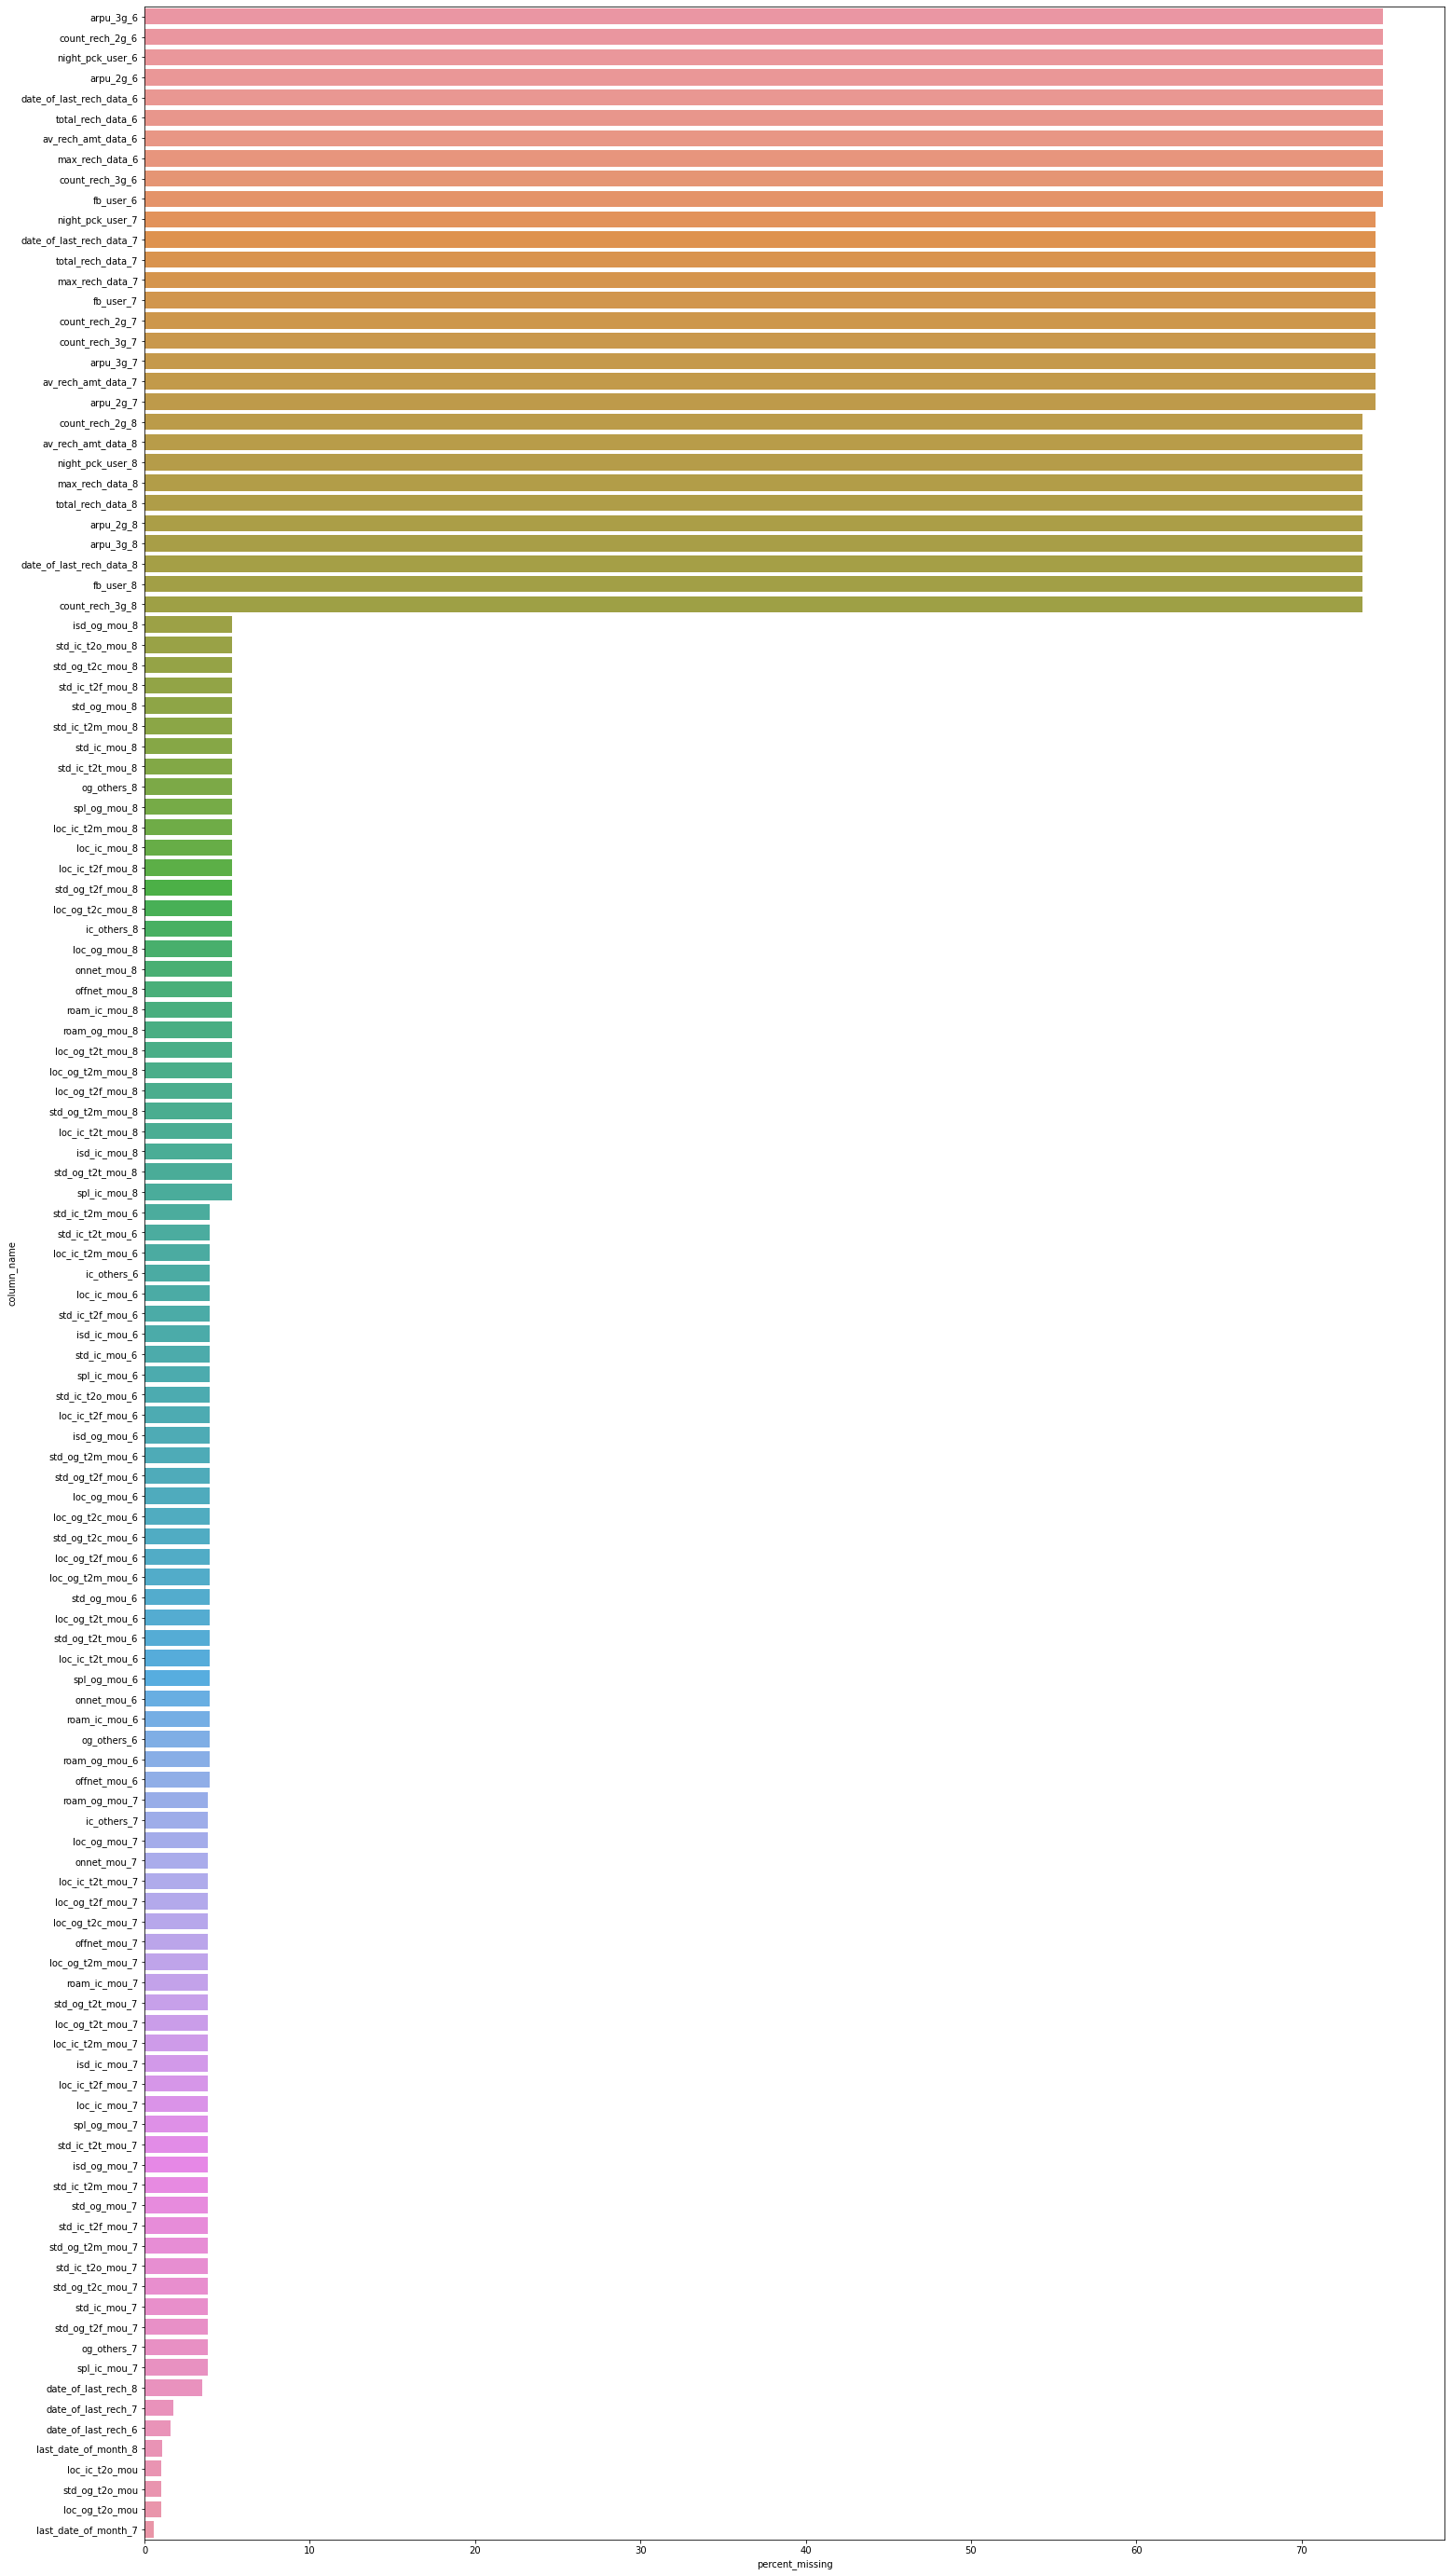

In [9]:

plot_missing_values(df_train,25,50)


> Function to impute values 

In [10]:

def impute_columns (df, imputes=False, mising_columns=False):
    # Function impute the nan with 0
    # argument: colList, list of columns for which nan is to be replaced with 0
    if imputes:
        for col in [impute + suffix for suffix in ['_6','_7','_8'] for impute in imputes]:
            df[col].fillna(0, inplace=True)
    else:    
        for col in mising_columns:
            df[col].fillna(0, inplace=True)




> Business Related Columns , we need to impute these , rather than drop the columns

In [11]:
 
biz_columns = ['arpu_3g','count_rech_2g','night_pck_user','arpu_2g','total_rech_data','av_rech_amt_data','max_rech_data','count_rech_3g','fb_user']
impute_columns(df_train,biz_columns)
impute_columns(df_test,biz_columns)

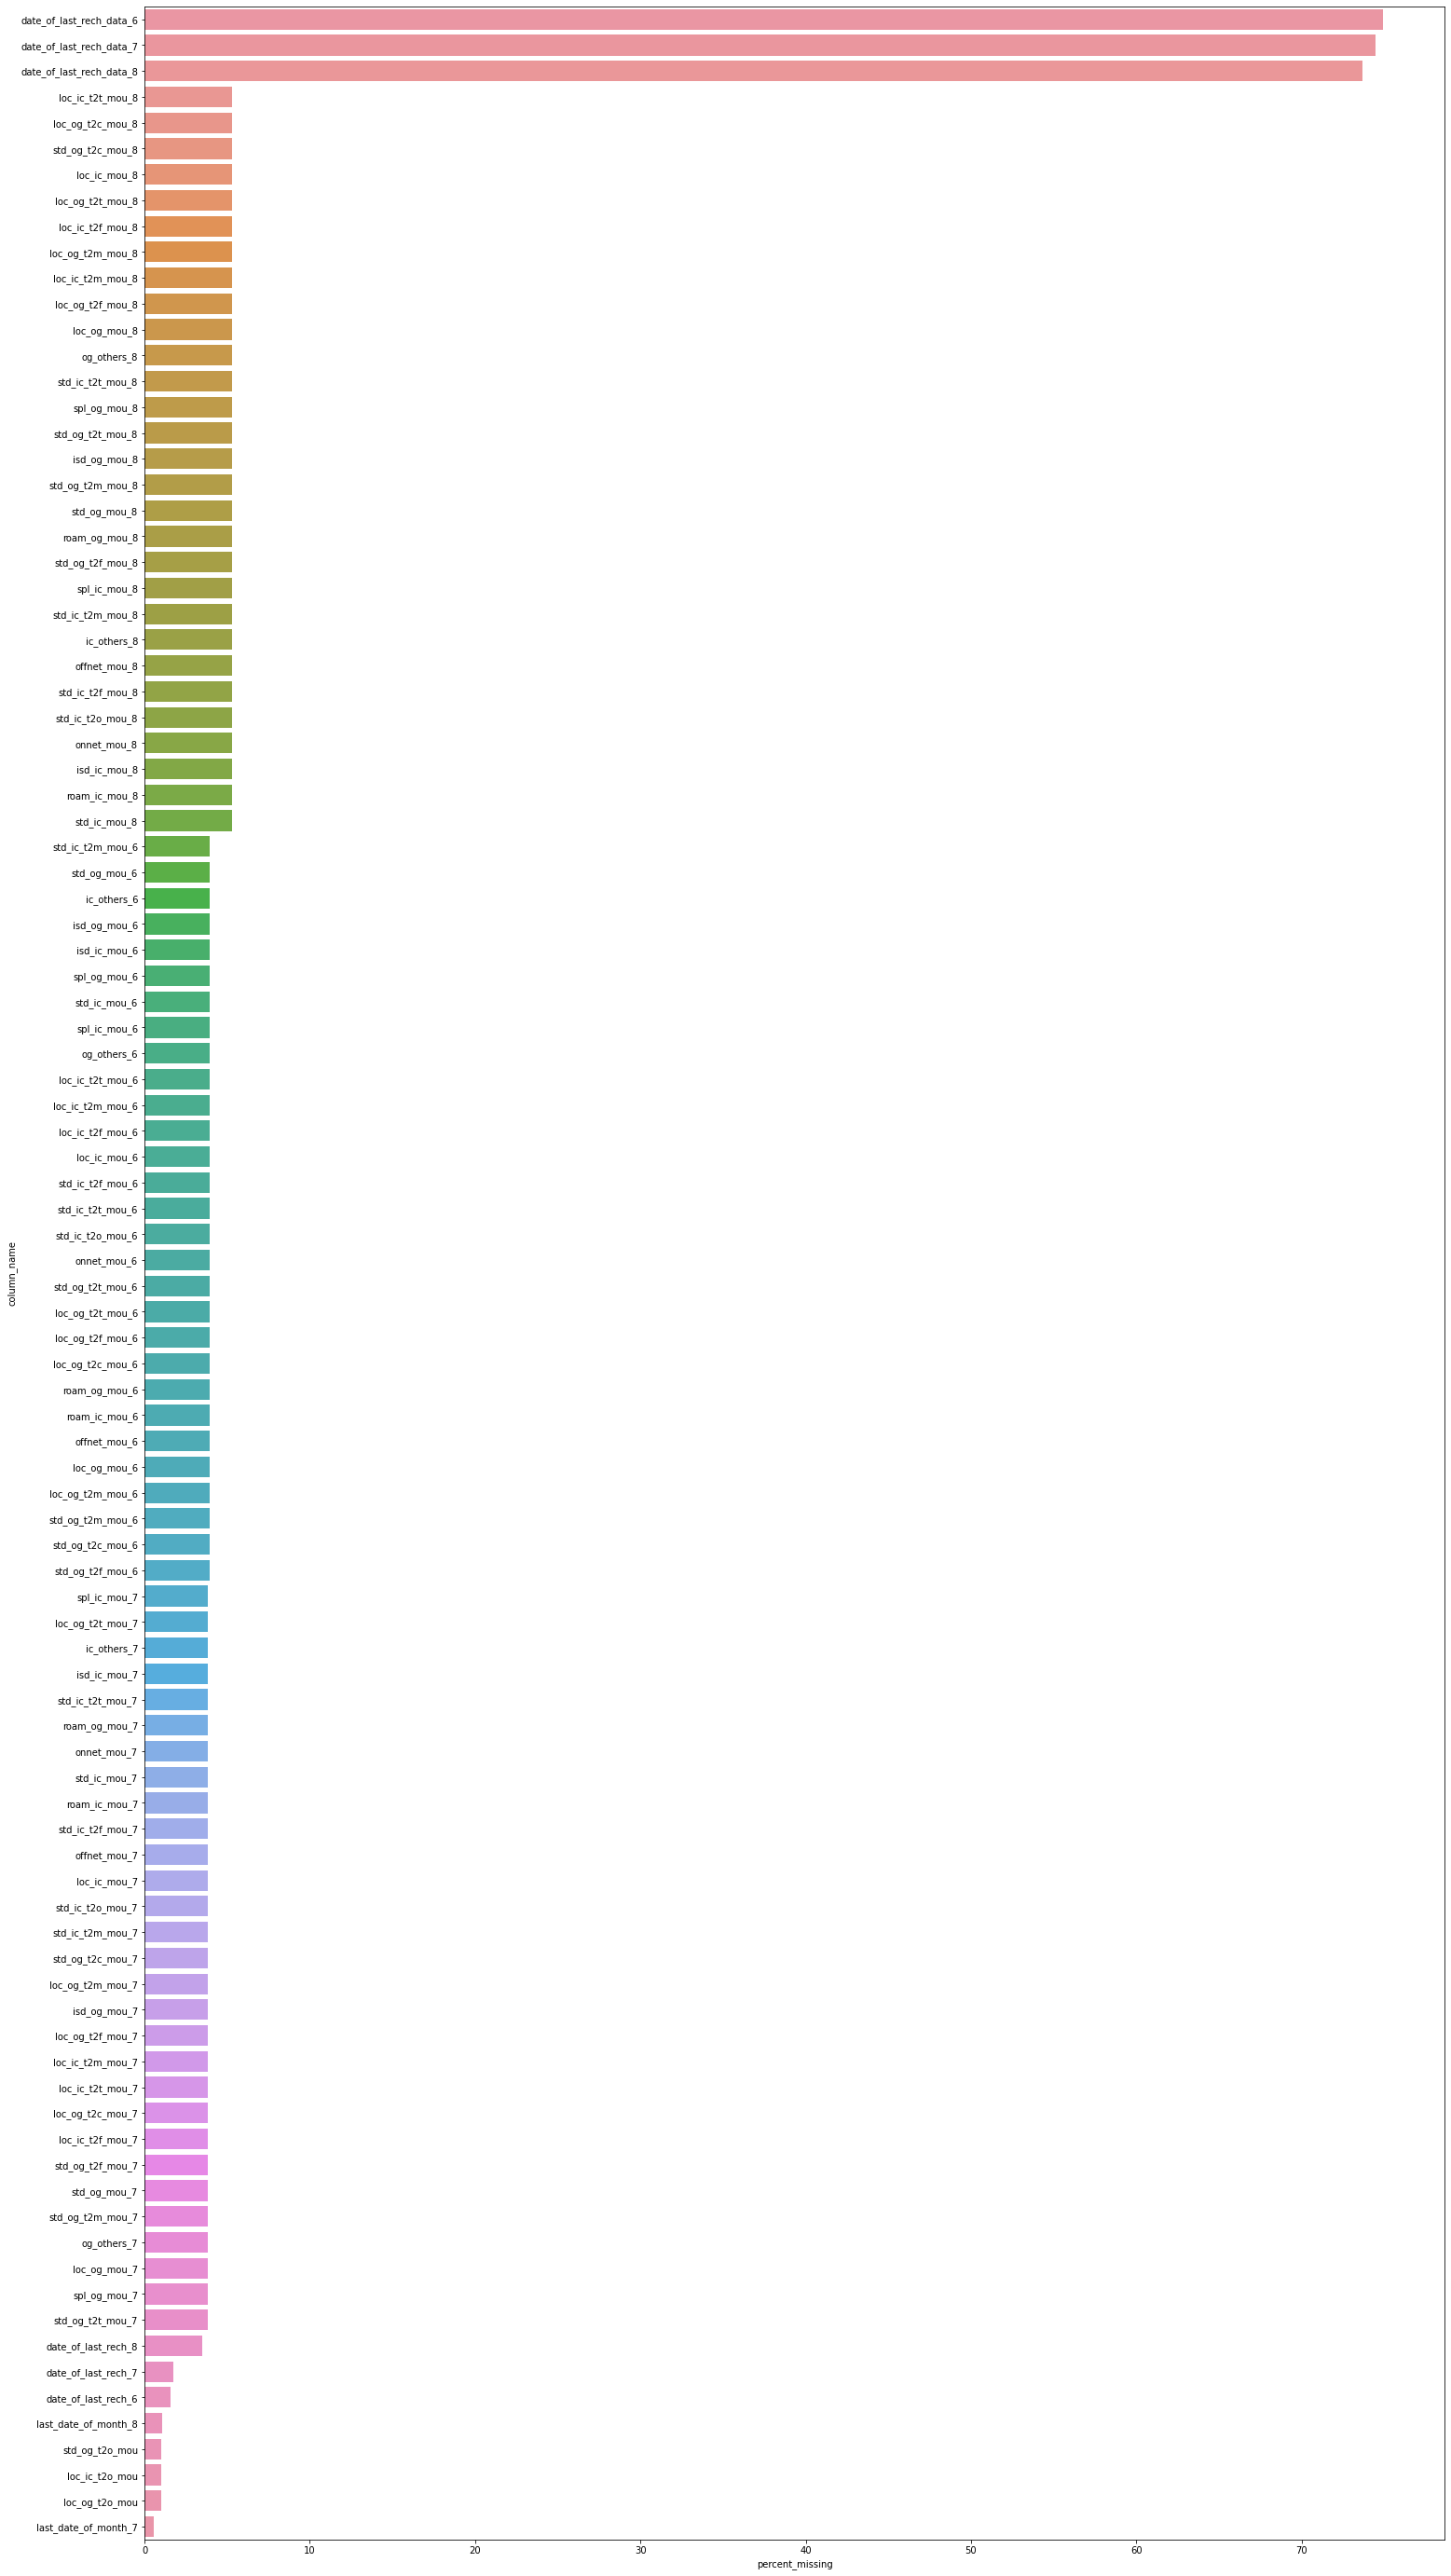

In [12]:
# check null value
plot_missing_values(df_train,25,50)



In [13]:
# impute the stats columns 
interesting_columns = ['loc_og_t2c_mou','std_ic_t2t_mou','loc_og_t2t_mou','loc_og_t2m_mou',
                       'std_ic_t2f_mou','loc_og_t2f_mou','std_ic_t2m_mou','loc_og_mou',
                       'std_og_t2t_mou','std_og_t2m_mou','std_og_t2f_mou','std_ic_t2o_mou',
                       'std_og_t2c_mou','std_og_mou','loc_ic_mou','isd_og_mou',
                       'spl_og_mou','og_others','loc_ic_t2f_mou','loc_ic_t2m_mou',
                       'roam_og_mou','loc_ic_t2t_mou','spl_ic_mou','ic_others',
                       'roam_ic_mou','onnet_mou','isd_ic_mou','offnet_mou','std_ic_mou']

impute_columns(df_train,imputes=interesting_columns)
impute_columns(df_test,imputes=interesting_columns)

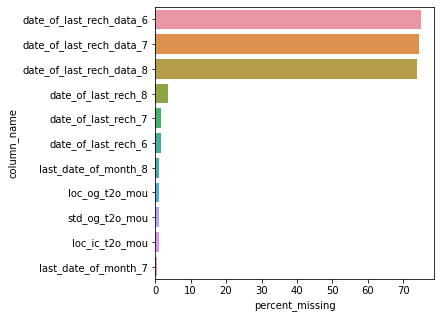

In [14]:
# check null value
plot_missing_values(df_train,5,5)


> date column treatment

In [15]:

last_day_data_columns = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']
df_train[df_train['date_of_last_rech_data_6'].isnull()]['date_of_last_rech_data_6'] = '6/30/2014'
df_train[df_train['date_of_last_rech_data_7'].isnull()]['date_of_last_rech_data_7'] = '7/31/2014'
df_train[df_train['date_of_last_rech_data_8'].isnull()]['date_of_last_rech_data_8'] = '8/31/2014'

df_test[df_test['date_of_last_rech_data_6'].isnull()]['date_of_last_rech_data_6'] = '6/30/2014'
df_test[df_test['date_of_last_rech_data_7'].isnull()]['date_of_last_rech_data_7'] = '7/31/2014'
df_test[df_test['date_of_last_rech_data_8'].isnull()]['date_of_last_rech_data_8'] = '8/31/2014'


> check values for uniqueness

In [16]:

unique_value_columns = ['last_date_of_month_8','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','last_date_of_month_7']
for col in unique_value_columns:
    print(df_train[col].unique())
    

['8/31/2014' nan]
[ 0. nan]
[ 0. nan]
[ 0. nan]
['7/31/2014' nan]


In [17]:
for col in unique_value_columns:
    print(df_test[col].unique())

['8/31/2014' nan]
[ 0. nan]
[ 0. nan]
[ 0. nan]
['7/31/2014' nan]


In [18]:
for col in unique_value_columns:
   df_train.fillna(df_train[col].mode()[0],inplace=True)
   df_test.fillna(df_test[col].mode()[0],inplace=True)

In [19]:
plot_missing_values(df_train,5,5)
df_train.shape

No data available


(69999, 172)

In [20]:
plot_missing_values(df_test,5,5)
df_test.shape

No data available


(30000, 171)

> Find Columns with Single Values  and drop them as they are not useful

In [21]:

single_valued_columns = df_train.columns[df_train.nunique() <= 1]
single_valued_columns

Index(['circle_id', 'last_date_of_month_6', 'last_date_of_month_8',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'],
      dtype='object')

In [22]:
single_value_drop_columns = ['std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',
                             'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','circle_id']
df_train.drop(single_value_drop_columns,axis=1,inplace=True)
df_test.drop(single_value_drop_columns,axis=1,inplace=True)

In [23]:
df_train.shape

(69999, 165)

In [24]:
len(df_train.id.value_counts())
#remove id
df_train.drop(['id'],axis=1,inplace=True)
df_test.drop(['id'],axis=1,inplace=True)

In [25]:
df_train.reset_index(inplace=True,drop=True)
df_train.shape
df_test.reset_index(inplace=True,drop=True)
df_test.shape

(30000, 163)

> Format Date Columns

In [26]:

dates = list(df_train.filter(regex='date').columns)
dates

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [27]:
for date_column in dates:
    df_train[date_column] = pd.to_datetime(df_train[date_column], format='%m/%d/%Y')
    df_test[date_column] = pd.to_datetime(df_test[date_column], format='%m/%d/%Y')

>  Find and drop object columns

In [28]:
df_train.info()

for dtype_col in df_train.columns:
    if df_train[dtype_col].dtype == object:
        print(dtype_col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 164 entries, loc_og_t2o_mou to churn_probability
dtypes: datetime64[ns](9), float64(126), int64(26), object(3)
memory usage: 87.6+ MB
loc_og_t2o_mou
std_og_t2o_mou
loc_ic_t2o_mou


In [29]:
df_train.loc_ic_t2o_mou.unique()
object_columns = ['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou']
df_train.drop(object_columns,axis=1,inplace=True)
df_test.drop(object_columns,axis=1,inplace=True)


In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 161 entries, last_date_of_month_6 to churn_probability
dtypes: datetime64[ns](9), float64(126), int64(26)
memory usage: 86.0 MB


> rename to conventional column names

In [31]:
unconventional_columns = list(df_train.filter(regex='vbc').columns)
unconventional_columns


['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']

In [32]:

df_train.rename(columns={'aug_vbc_3g' : 'vbc_3g_8', 'jul_vbc_3g' : 'vbc_3g_7', 'jun_vbc_3g' : 'vbc_3g_6'}, inplace=True)
df_test.rename(columns={'aug_vbc_3g' : 'vbc_3g_8', 'jul_vbc_3g' : 'vbc_3g_7', 'jun_vbc_3g' : 'vbc_3g_6'}, inplace=True)

>  Check for Skewness

In [33]:

for col_name in df_train.columns:
    if (len(df_train[col_name].unique()) <= 8):
        print(df_train[col_name].value_counts())
        print(f"\n{35 * '-'}")

2014-06-30    69999
Name: last_date_of_month_6, dtype: int64

-----------------------------------
2014-07-31    69600
2014-08-31      399
Name: last_date_of_month_7, dtype: int64

-----------------------------------
2014-08-31    69999
Name: last_date_of_month_8, dtype: int64

-----------------------------------
0.0    69555
1.0      444
Name: night_pck_user_6, dtype: int64

-----------------------------------
0.0    69569
1.0      430
Name: night_pck_user_7, dtype: int64

-----------------------------------
0.0    69612
1.0      387
Name: night_pck_user_8, dtype: int64

-----------------------------------
0    64896
1     4688
2      389
3       20
4        6
Name: monthly_2g_6, dtype: int64

-----------------------------------
0    64695
1     4806
2      467
3       27
4        3
5        1
Name: monthly_2g_7, dtype: int64

-----------------------------------
0    64817
1     4738
2      413
3       24
4        6
5        1
Name: monthly_2g_8, dtype: int64

-------------------------

> Find Highly correlated data and drop Highly Correlated Columns

In [34]:
df_train_2 = df_train.copy()

cor = df_train_2.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values(ascending=False)


sachet_2g_8       count_rech_2g_8       0.983562
sachet_2g_7       count_rech_2g_7       0.983300
sachet_2g_6       count_rech_2g_6       0.980998
total_rech_amt_8  arpu_8                0.958333
total_rech_amt_7  arpu_7                0.955298
                                          ...   
arpu_3g_7         vol_3g_mb_8           0.603865
total_og_mou_7    onnet_mou_8           0.603600
vol_3g_mb_7       av_rech_amt_data_6    0.602328
offnet_mou_7      arpu_7                0.600463
monthly_3g_7      max_rech_data_7       0.600074
Length: 304, dtype: float64

## PCA

In [35]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
df_train.drop(dates,axis=1,inplace=True)




In [36]:
df_3 = df_train_2.select_dtypes(exclude=['datetime64'])
df_3.info()

X = df_3.drop(['churn_probability'], axis=1)
y = df_3['churn_probability']

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

df_4 = df_test.select_dtypes(exclude=['datetime64'])
X1_test = df_4.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 152 entries, arpu_6 to churn_probability
dtypes: float64(126), int64(26)
memory usage: 81.2 MB


In [37]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

#Improting the PCA module
pca = PCA(random_state=100)

#Doing the PCA on the train data
pca.fit(X_tr)

X_tr_pca = pca.fit_transform(X_tr)
print(X_tr_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

X_tr_pca_1 = X_tr_pca.copy()
X_test_pca_1 = X_test_pca.copy()

X_tr_pca_2 = X_tr_pca.copy()
X_test_pca_2 = X_test_pca.copy()

(88086, 151)
(88086,)
(88086, 151)
(21000, 151)


In [38]:
from sklearn.linear_model import LogisticRegression
lr_pca = LogisticRegression(max_iter=500)
lr_pca.fit(X_tr_pca, y_tr)

# Predicted probabilities
y_pred = lr_pca.predict(X_test_pca)

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [39]:
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
conf_mat = confusion_matrix(y_test,y_pred)
print(conf_mat)

[[15156  3668]
 [  332  1844]]


In [40]:
TP = conf_mat[1,1]
# Substituting the value of true negatives
TN = conf_mat[0,0]
# Substituting the value of false positives
FP = conf_mat[0,1] 
# Substituting the value of false negatives
FN = conf_mat[1,0]

# Calculating the sensitivity
sens_log_pca=TP/(TP+FN)

# Calculating the specificity
spec_log_pca=TN/(TN+FP)

print("Sensitivity:" ,sens_log_pca)
print("Specificity:" ,spec_log_pca)


Sensitivity: 0.8474264705882353
Specificity: 0.805142371440714


In [41]:

print("Logistic Regression accuracy with PCA: ",accuracy_score(y_test,y_pred))

Logistic Regression accuracy with PCA:  0.8095238095238095


In [42]:
df_5=df_3.copy()
df_5.drop('churn_probability', axis=1,inplace=True)
col = list(df_5.columns)
df_pca = pd.DataFrame({'PCA1':pca.components_[0],'PCA2':pca.components_[1], 'PCA3':pca.components_[2],'Feature':col})
df_pca.head(10)



,PCA1,PCA2,PCA3,Feature
0,0.164932,-0.082276,-0.061553,arpu_6
1,0.182756,-0.072758,-0.044523,arpu_7
2,0.162149,-0.045015,0.000457,arpu_8
3,0.092370,-0.146335,-0.100596,onnet_mou_6
4,0.102549,-0.135864,-0.086835,onnet_mou_7
5,0.089303,-0.096351,-0.040082,onnet_mou_8
6,0.127695,-0.153166,-0.061639,offnet_mou_6
7,0.136225,-0.139295,-0.044819,offnet_mou_7
8,0.113468,-0.091552,0.002728,offnet_mou_8
9,0.017533,-0.015529,-0.027205,roam_ic_mou_6


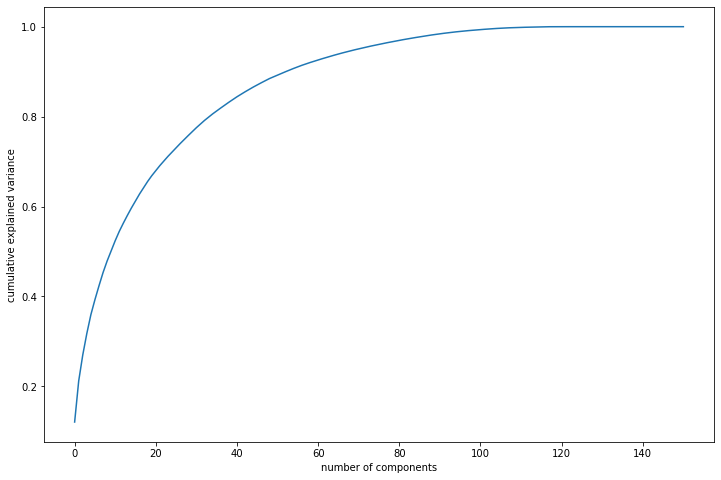

In [43]:
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [44]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 12.08,  21.2 ,  26.99,  31.76,  35.95,  39.29,  42.37,  45.31,
        47.87,  50.17,  52.41,  54.48,  56.31,  58.04,  59.7 ,  61.25,
        62.8 ,  64.21,  65.59,  66.85,  67.99,  69.1 ,  70.14,  71.15,
        72.11,  73.06,  74.  ,  74.9 ,  75.79,  76.66,  77.53,  78.35,
        79.15,  79.89,  80.6 ,  81.26,  81.91,  82.55,  83.18,  83.8 ,
        84.4 ,  84.96,  85.51,  86.05,  86.56,  87.06,  87.53,  88.  ,
        88.46,  88.85,  89.24,  89.62,  90.  ,  90.37,  90.73,  91.07,
        91.41,  91.72,  92.02,  92.31,  92.59,  92.87,  93.14,  93.41,
        93.67,  93.92,  94.16,  94.39,  94.62,  94.84,  95.05,  95.26,
        95.47,  95.67,  95.86,  96.05,  96.24,  96.42,  96.6 ,  96.77,
        96.94,  97.11,  97.27,  97.42,  97.57,  97.72,  97.87,  98.01,
        98.15,  98.28,  98.41,  98.53,  98.64,  98.75,  98.85,  98.95,
        99.04,  99.12,  99.2 ,  99.27,  99.34,  99.41,  99.48,  99.55,
        99.61,  99.66,  99.71,  99.75,  99.79,  99.82,  99.85,  99.88,
      

In [45]:
pca_54 = PCA(n_components=54)

df_tr_pca_54 = pca_54.fit_transform(X_tr)
print(df_tr_pca_54.shape)

df_test_pca_54 = pca_54.transform(X_test)
print(df_test_pca_54.shape)

(88086, 54)
(21000, 54)


In [46]:
# Let's run the model using the selected variables
lr_pca1 = LogisticRegression(max_iter=500)
lr_pca1.fit(df_tr_pca_54, y_tr)

# Predicted probabilities
y_pred54 = lr_pca1.predict(df_test_pca_54)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred54)

conf_matrices = confusion_matrix(y_test,y_pred54)

# check sensitivity and specificity

# Substituting the value of true positive
TP = conf_matrices[1,1]
# Substituting the value of true negatives
TN = conf_matrices[0,0]
# Substituting the value of false positives
FP = conf_matrices[0,1] 
# Substituting the value of false negatives
FN = conf_matrices[1,0]

# Calculating the sensitivity
sens_log_pca=TP/(TP+FN)

# Calculating the specificity
spec_log_pca=TN/(TN+FP)

print("Sensitivity:" ,sens_log_pca)
print("Specificity:" ,spec_log_pca)

Sensitivity: 0.8368566176470589
Specificity: 0.7938270293242669


In [47]:
print("Logistic Regression accuracy with PCA: ",accuracy_score(y_test,y_pred54))

Logistic Regression accuracy with PCA:  0.7982857142857143


In [48]:
# Tuning hyper parameters 
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_tr_pca_1, y_tr)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [49]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.671204,0.025225,0.006124,0.000826,0.01,{'C': 0.01},0.876196,0.879489,0.875813,0.876269,0.872008,0.875955,0.002377,6,0.876953,0.876524,0.876538,0.875942,0.877002,0.876592,0.000382
1,0.796770,0.033566,0.005590,0.000489,0.1,{'C': 0.1},0.875854,0.879602,0.877067,0.877622,0.873034,0.876636,0.002170,5,0.877237,0.877234,0.876821,0.876482,0.877598,0.877074,0.000385
2,0.810503,0.034647,0.005713,0.000875,1,{'C': 1},0.875626,0.880054,0.876611,0.878299,0.872692,0.876657,0.002491,4,0.877293,0.877234,0.877162,0.876425,0.878023,0.877228,0.000507
3,0.775554,0.025741,0.005341,0.001055,10,{'C': 10},0.875854,0.880280,0.876383,0.878299,0.872578,0.876679,0.002576,3,0.877492,0.877263,0.877133,0.876539,0.877881,0.877262,0.000442
4,0.759653,0.027698,0.004757,0.000150,100,{'C': 100},0.875968,0.880167,0.876725,0.878412,0.872806,0.876816,0.002473,2,0.877435,0.877178,0.877360,0.876539,0.877966,0.877296,0.000461
5,0.789468,0.014191,0.005176,0.000460,1000,{'C': 1000},0.875968,0.880393,0.876725,0.878525,0.872578,0.876838,0.002623,1,0.877492,0.877519,0.877275,0.876539,0.877966,0.877358,0.000467


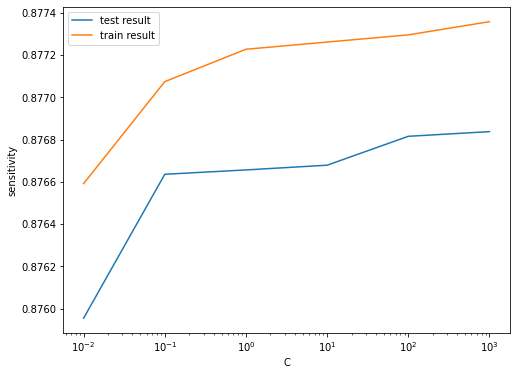

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [51]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))


 The highest test sensitivity is 0.876837750160869 at C = 1000


#### Logistic regression with optimal C


In [52]:


# Instantiate the model with best C
logistic_pca = LogisticRegression(C=best_C)

# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_tr_pca_1, y_tr)

# Predictions on the train set
y_train_pred = log_pca_model.predict(X_tr_pca_1)

# Confusion matrix
confusion = metrics.confusion_matrix(y_tr, y_train_pred)
print(confusion)

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_tr, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_pca)

# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

[[35236  8807]
 [ 5411 38632]]
Accuracy:- 0.8385895602025294
Sensitivity:- 0.8771427922711895
Specificity:- 0.8000363281338692
[[15149  3675]
 [  333  1843]]
Accuracy:- 0.8091428571428572
Sensitivity:- 0.8469669117647058
Specificity:- 0.8047705057373565


### Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1, random_state=42)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['sqrt', 0.4],'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=forest, cv=4, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)


# fit model
model.fit(X_tr_pca_2, y_tr)




Fitting 5 folds for each of 480 candidates, totalling 2400 fits


KeyboardInterrupt: 